In [10]:
source("/home/juan/Documentos/Rfunj/arranque_notebook.R")

In [11]:
#tema de graficación
library("ggplot2")
temajuan <- theme(
  legend.position = c(0.14, 0.80),
  legend.background = element_blank(),
  legend.title = element_text(size = 22),
  legend.box = "horizontal",
  legend.direction = "vertical",
  plot.title = element_text(size = 32),
  #legend.key.height = unit(0.1,"snpc"),
  legend.key.width  = unit(0.125,"snpc"),
  #legend.box.spacing = unit(0.1,"snpc"),
  legend.key = element_blank(),
  legend.spacing.x = unit(10, "pt"),
  legend.text = element_text(size = 24, margin = margin(t = 0, r= 5,b = 0, l = 3, unit = "pt")),
  axis.line = element_line(size = 0.5, lineend = "square"),
  axis.title = element_text(size = 32),
  axis.text.x = element_text(size = 28, colour = "black", angle = 0,  vjust = 1),
  axis.text.y = element_text(size = 28, colour = "black"),
  axis.ticks = element_line(size = 1, colour = "black"),
  panel.border = element_rect(size = 1, fill = NA)
)  

# Análisis de datos Labo 5

La idea es calibrar un sensor de movimiento.

Como calibrar es utilizar una señal (tiempo de vuelo o TOF) para utilizarla como indicadora de otra (en este caso, distancia), lo que tenemos que hacer es bastante fácil:

* Graficar tof vs. distancia medida con cinta métrica.
* hacer un ajuste y luego hacer la inversa (para obtener f(TOF) = d
* ver detalles de una calibración simple.

## Sensor HC-SR04

Este sensor tira un *burst* de sonidos de alta frecuancia (40 kHz), por lo que no escuchamos nada cuando funciona.

El sonido en el aire (tanto el de 20 como el de 40 kHz) viaja a una velocidad constante $c \equiv c(T)$, donde $T [K]$ es la temperatura del aire. Que no cambie la velocidad de la onda a diferentes frecuencias hacen del aire un medio *no dispersivo*, al menos en el rango de frecuencias indicado.

La velocidad del sonido es:

$$
c(T) = \frac{20.0514}{K} \; \sqrt{T}
$$

donde $T[K]$ es la temperatura en grados Kelvin ($0C = 273.15 K$, $100 C = 373.15 K$ ). Este modelo es el más simple, pero funciona muy bien en términos generales. Parte de asumir el aire como un gas ideal y proponer que el sonido no transporta calor alguno (la compresión y decompresión de las ondas es un proceso adiabático).

El sensor puede medir el tiempo entre la salida del *burst* de sonido y el arribo luego del rebote con un blanco a una distancia $d [m]$. A ese tiempo lo denominamos $TOF$ (*Time of Flight* o tiempo de vuelo) (1). Si asumimos una velocidad constante, tenemos:

$$
c = \frac{2d}{TOF} \Longrightarrow d(TOF) = \Big(\frac{1}{2c}\Big) TOF
$$

la idea es que la distancia es directamente proporcional al tiempo de vuelo...



(1) *Aquí usamos un nombre de variable un poco raro (tres letras en lugar de una) por cuestiones de abundancia: hay muchos equipos y técnicas de todo tipo que usan Tiempo de Vuelo.*



# Análisis de datos

### Datos de Fabricio

[1] "DATOS02.tsv" "DATOS03.tsv" "DATOS04.tsv" "DATOS05.tsv" "DATOS06.tsv"
 [6] "DATOS07.tsv" "DATOS08.tsv" "DATOS09.tsv" "DATOS10.tsv" "DATOS11.tsv"
[11] "DATOS12.tsv"

,d,TOF
,<dbl>,<int>
1,0.2,1140
2,0.2,1140
3,0.2,1139
4,0.2,1139
5,0.2,1140
6,0.2,1140


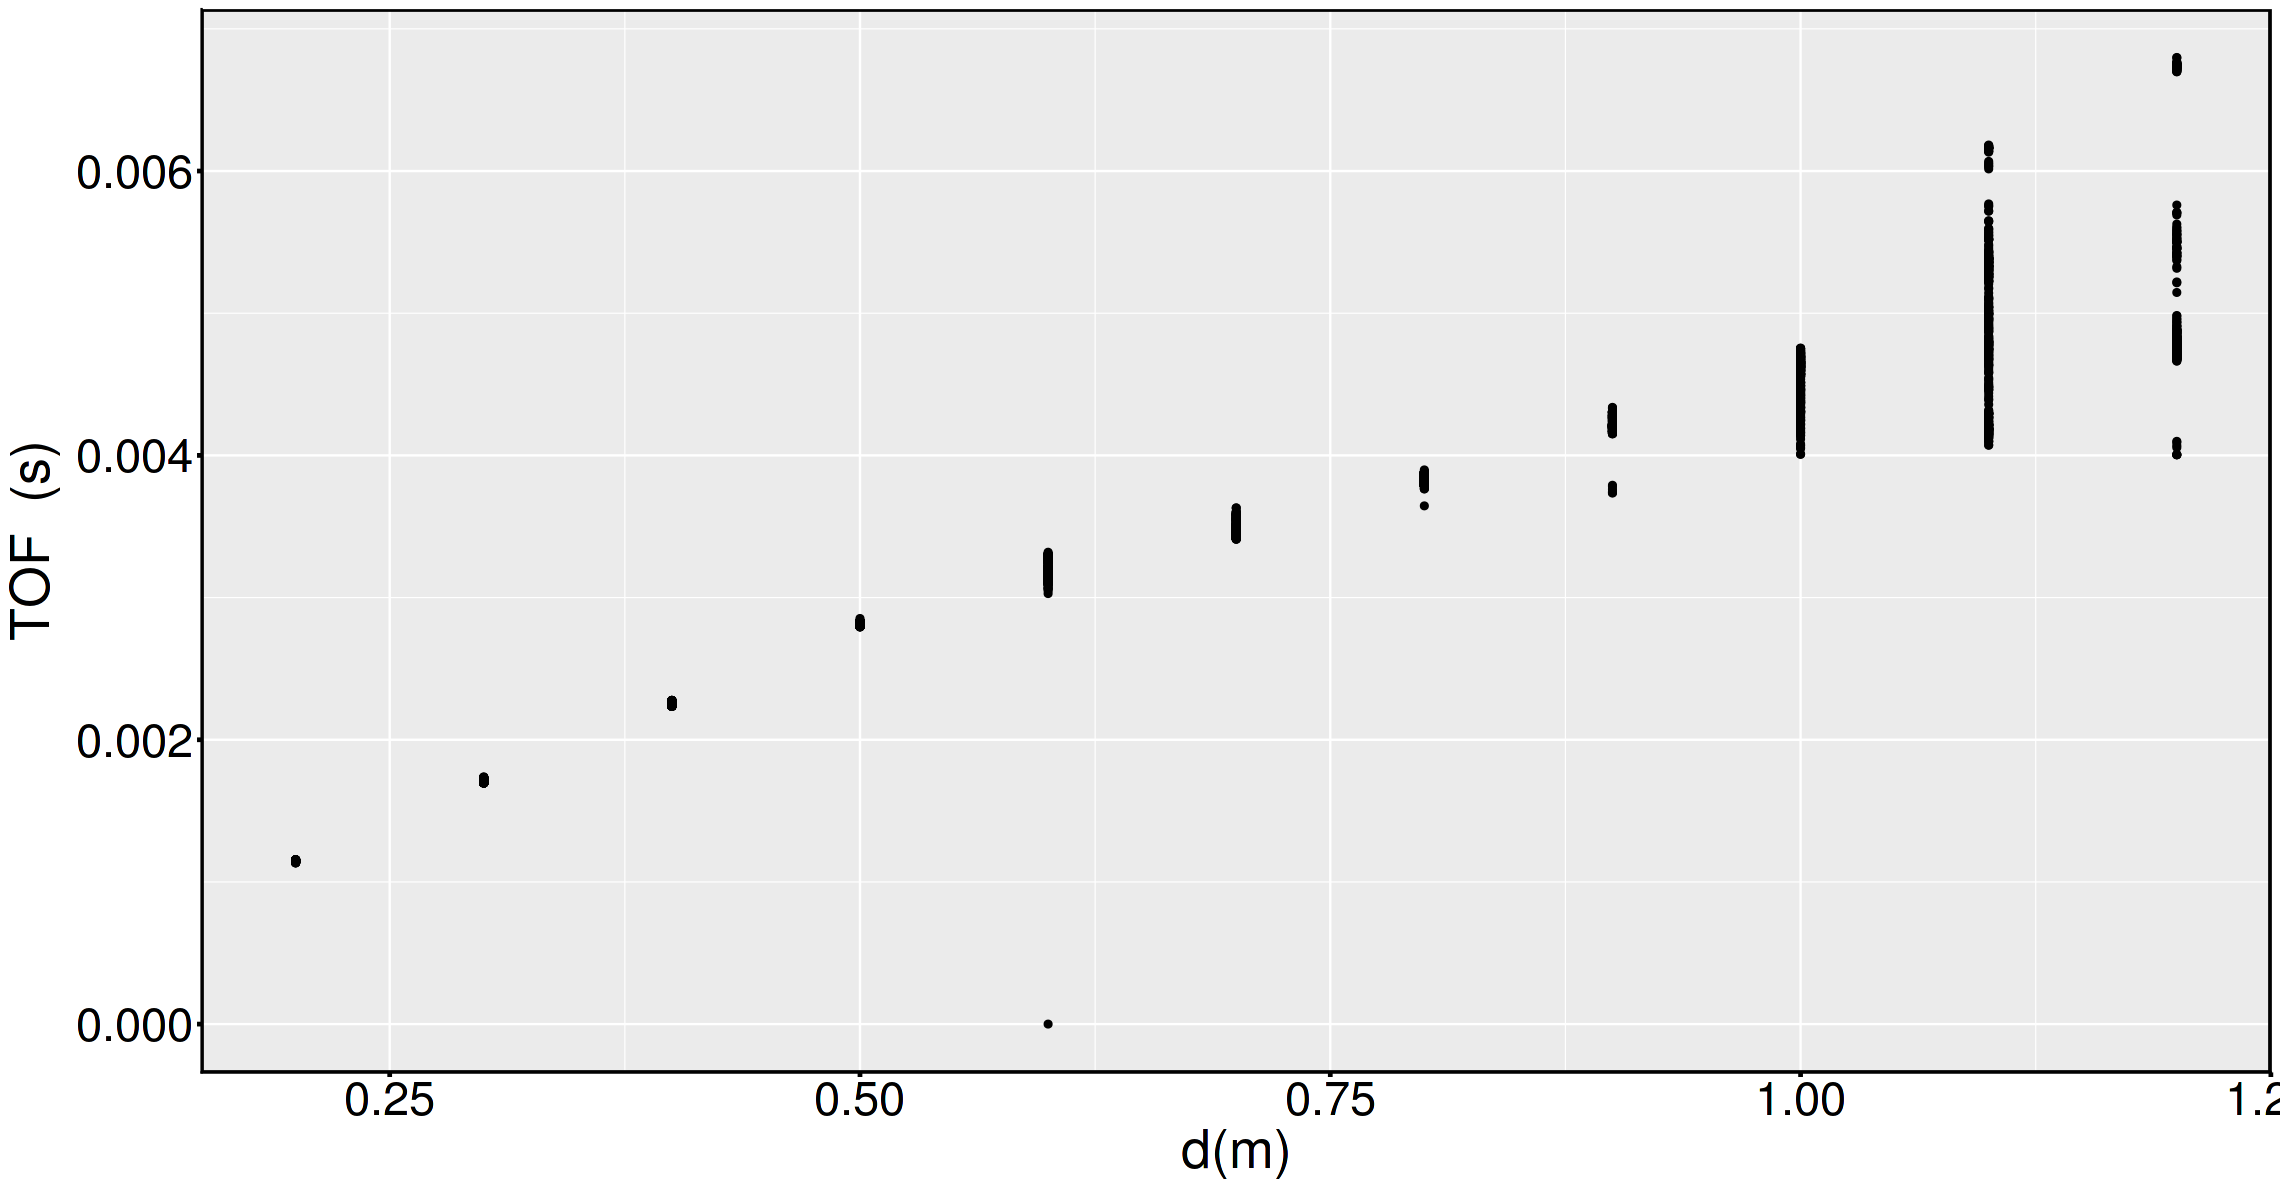

In [12]:
datos <- "/home/juan/Documentos/Docencia/fexpi/2024/DatosLabo5/datos/Fabricio/"
graf <- "/home/juan/Documentos/Docencia/fexpi/2024/DatosLabo5/graf/"
setwd(datos)

archivos <- list.files(pattern = ".tsv"); archivos

datos <- data.frame();

for(i in archivos){

    datos.de.un.archivo <- read.csv(i, sep = "\t", header = T);    

    datos <- rbind(datos, datos.de.un.archivo);
    }

colnames(datos) <- c("d", "TOF");
head(datos)


datos$TOF <- datos$TOF/10^6

gtd <- ggplot() + 
geom_point(data = datos, aes(x = d, y = TOF)) +
temajuan + xlab(TeX("$d (m)$")) + ylab(TeX("$TOF \\; (s)$")) + 
theme(legend.box = "vertical", legend.position = c(0.2,0.7))
            

fig(19,10)
show(gtd)

Lo que veo:
* Un outlier TOF  = 0 (hay que sacarlo)

* Claramente dos pendientes:
    * Una para distancias 0 m < d < 0.5 m
    * Otra para 0.5 m < d < 1.2 m
    
    Veamos con valores del modelo y el ajuste lineal. Sabemos que:
    
    $$
    TOF(d) = \frac{2}{c}\; d 
    $$
    
    entonces graficamos esta función para dos valores de temperatura, c(T).

In [13]:
velson <- function(T){20.0514 * sqrt(T + 273.15)};
cat(bold("v_sonido ( 25 C) = ", velson(25), "m s⁻¹\n"))
cat(bold("v_sonido (650 C) = ", velson(650), "m s⁻¹\n"))

v_sonido ( 25 C) =  346.227936626111 m s⁻¹
v_sonido (650 C) =  609.229378252046 m s⁻¹


Ahora lo vemos en gráfico.
Los valores los selecconé a ojo. A la recta armada con 650 °C le puse una ordenada al origen mayor a cero.

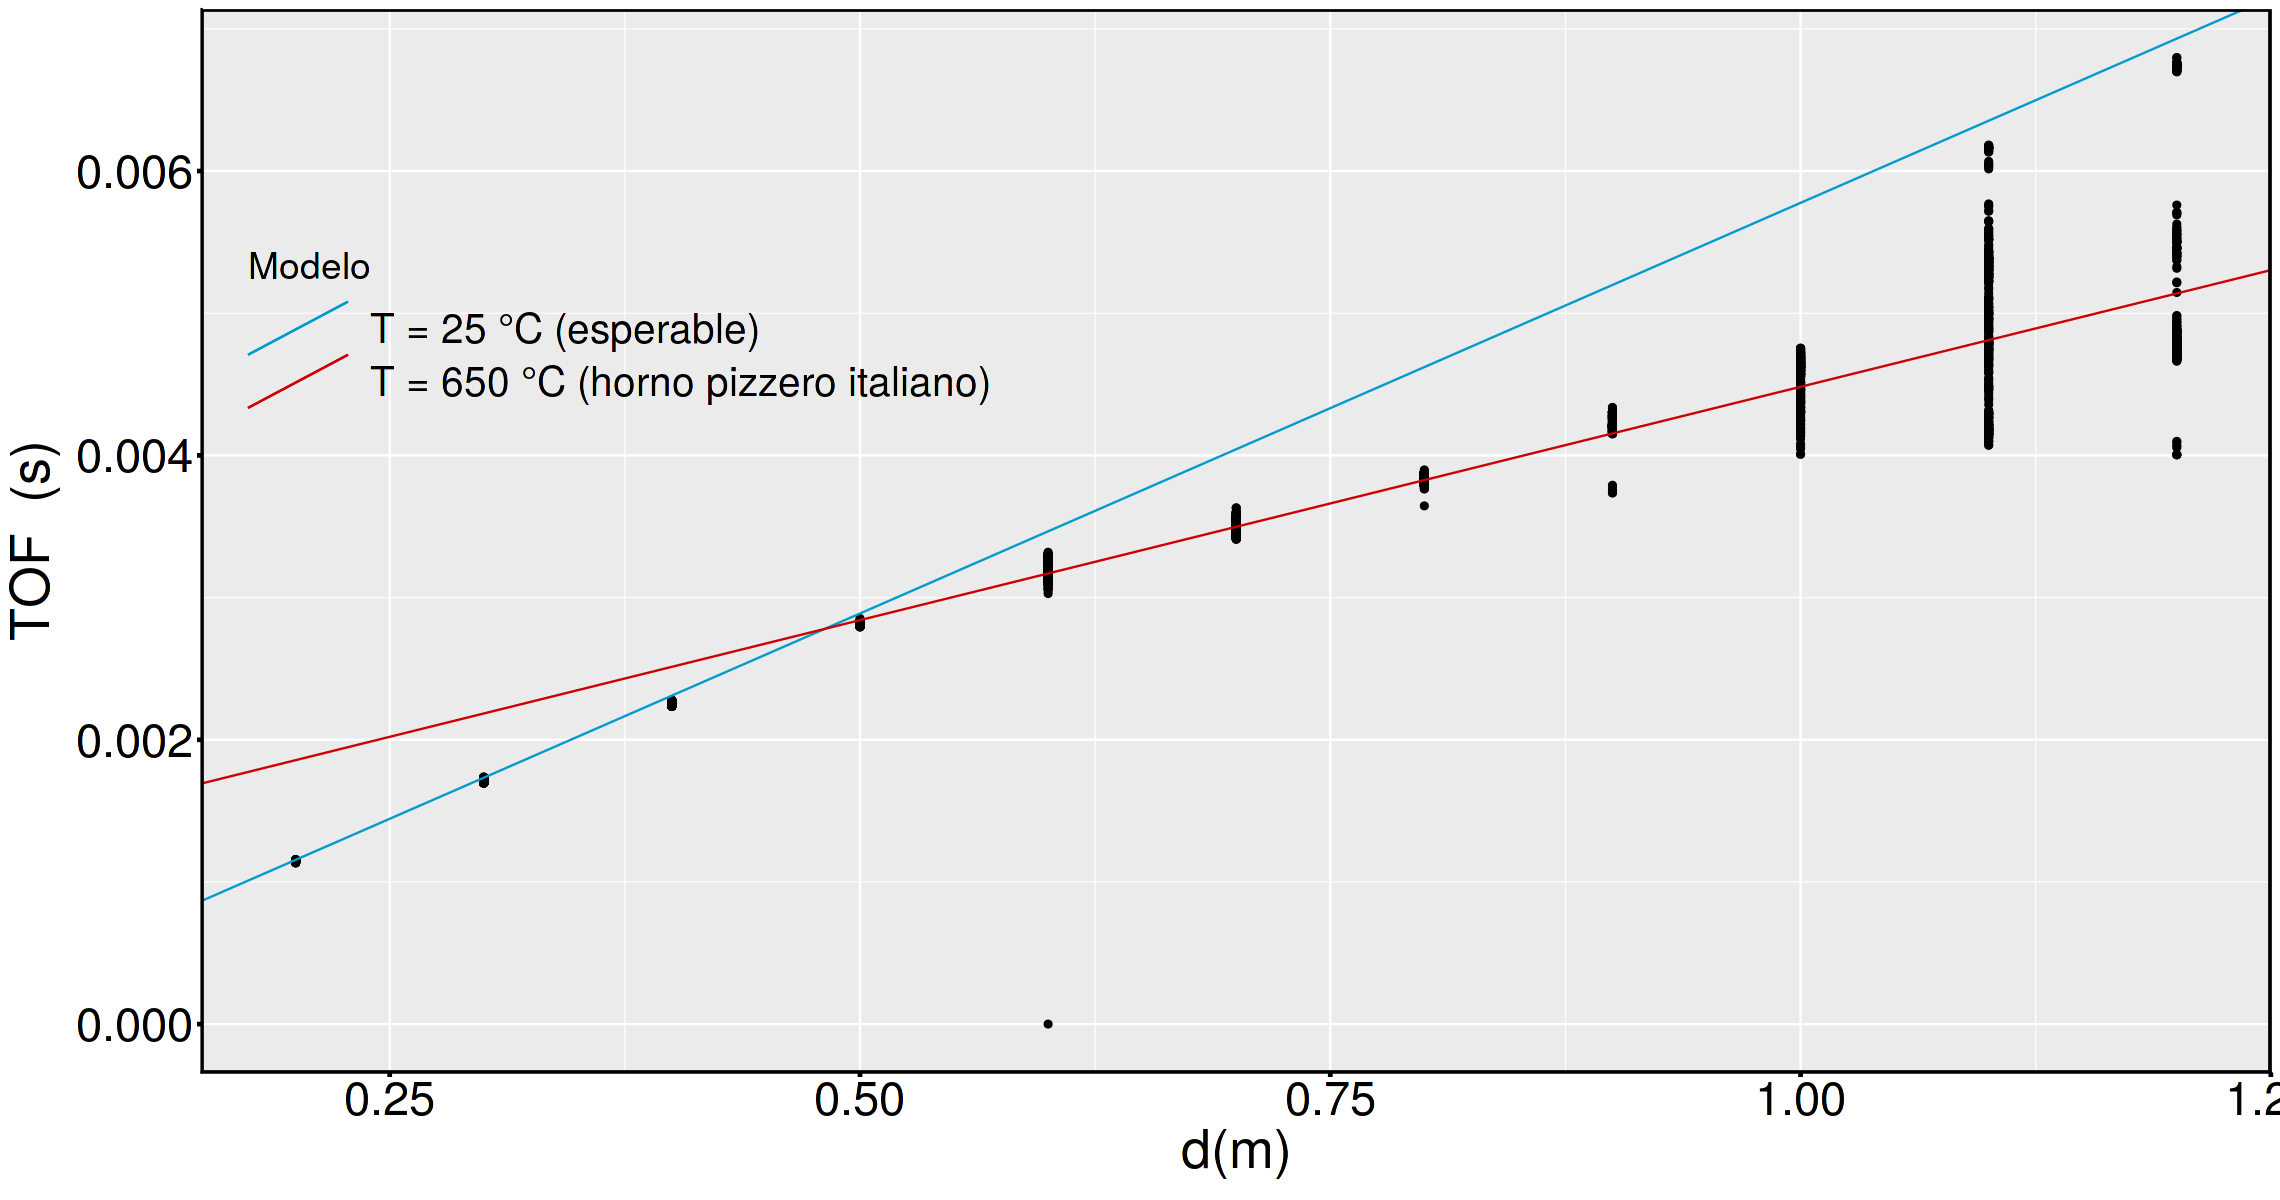

In [14]:
gtd +
geom_abline(aes(intercept = 0, slope = 2/velson(25) , colour = "25") ) + 
geom_abline(aes(intercept = 0.0012, slope = 2/velson(650) , colour = "650")) + 
scale_colour_manual(values = c("25" = "DeepSkyBlue3", "650" = "Red3"), 
                    labels = c("T = 25 °C (esperable)", "T = 650 °C (horno pizzero italiano)"), name = "Modelo" ) + 
theme(legend.key.height = unit(32,"pt"))

Claramente los datos son descriptos por dos rectas, pero en intervalos de $d$ diferentes.

Pareciera que están rebotando contra algo más cercano que el supuesto blanco. También es notable que los tiempos de vuelo cerca de $d$ parecen estar agrupados en diferentes nubes: los valores más altos parecen estar más cerca de la recta azul.

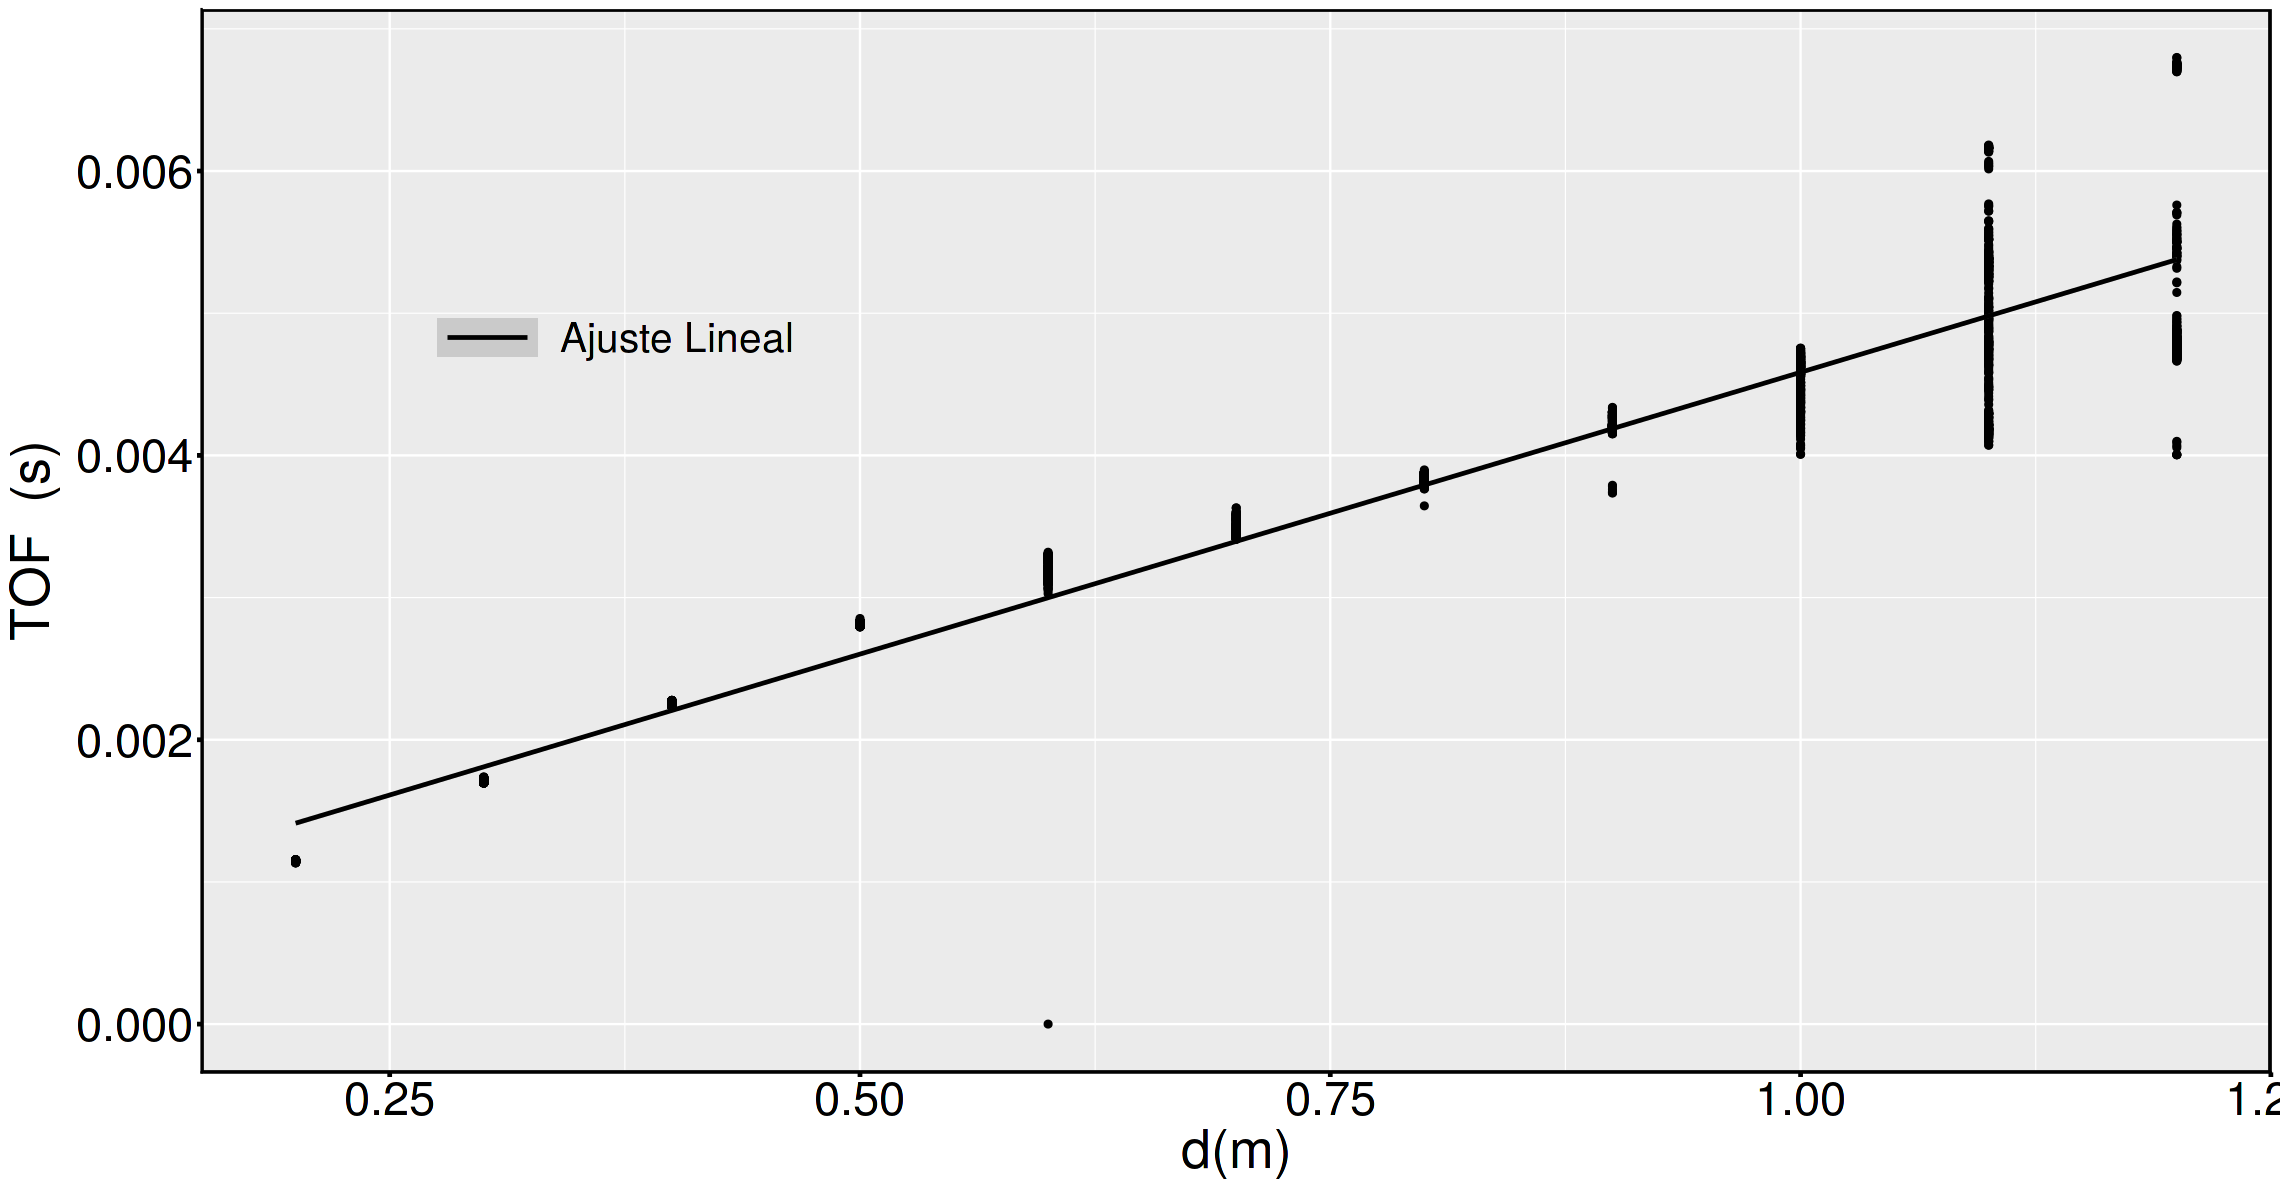

In [15]:
gtd +
geom_smooth(data = datos,aes(x= d, y = TOF, lty = "Ajuste Lineal"), colour = "Black", method = "lm", formula = "y ~ x") + 
scale_linetype_manual(values = c("Ajuste Lineal" = 1), name = NULL)

## Ajustes lineales (2 ajustes)

### Ajustamos todos los datos.

In [17]:
aju <- summary.lm(lm(datos$TOF ~ datos$d))
#velocidad del sonido a partir del ajuste
vs <- 2/aju$coefficients[2,1]
svs <- (2/aju$coefficients[2,1]^2) * aju$coefficients[2,2]

cat(bold("vs +- s = (", round(vs,4), " +- ", round(svs, 4), ")m s⁻¹"))

vs +- s = ( 504.4951  +-  2.0053 )m s⁻¹

La incerteza es muy chiquita, pero eso sólo se debe a la enorme cantidad de puntos.

Aquí la incerteza ni siquiera llega a cubrir el valor esperado, que es de unos 340 m/s.


### Ajustamos sólo los datos del principio (distancias menores a 0.5 m).
Intentemos con un ajuste de los primeros cuatro valores de $d$:

In [18]:
#primeros cuatro valores de d
aju2 <- summary.lm(lm(datos$TOF[datos$d < 0.52] ~ datos$d[datos$d < 0.52]))
#velocidad del sonido a partir del ajuste
vs2 <- 2/aju2$coefficients[2,1]
svs2 <- (2/aju2$coefficients[2,1]^2) * aju$coefficients[2,2]

In [19]:
cat(bold("Segundo intento\n\nvs +- s = (", round(vs2,4), " +- ", round(svs2, 4), ")m s⁻¹"))

Segundo intento

vs +- s = ( 359.4418  +-  1.0179 )m s⁻¹

Este mejoró mucho, porque es donde la calibración funcionó bien...o más o menos bien. No esperemos mucho de la incerteza en vs, porque nada tiene que ver con pifiarle 10 metros por segundo a la velocidad esperada.

Sin embargo, si calculamos desde este valor de velocidad del sonido una temperatura, tenemos:

In [18]:
Testimada <- (vs2/20.0514)^2; sT <- 2*vs2*svs2 / 20.0514^2;
cat(bold("T(vs) +- s = (", round(Testimada-271.15,4), " +- ", round(sT, 4), ")°C"))

T(vs) +- s = ( 50.1922  +-  1.8201 )°C

Y, obvio, no hacían 50 grados....

Esto es perfectamente esperable, porque la velocidad del sonido es muy mala como termómetro...¿por qué? Porque pequeños errores sistemáticos en la velocidad hacen estragos con la temperatura.

### Tercer intento de ajuste.

Usamos los puntos con $d \leq 0.5 m$, pero le restamos la ordenada al origen, pequeña pero persistente a cada punto

In [19]:
aju3 <- summary.lm(lm( (datos$TOF[datos$d < 0.52] - aju2$coefficients[1,1]) ~ datos$d[datos$d < 0.52]))
#velocidad del sonido a partir del ajuste
vs3 <- 2/aju3$coefficients[2,1]
svs3 <- (2/aju3$coefficients[2,1]^2) * aju$coefficients[2,2]

In [20]:
cat(bold("Segundo intento\n\nvs +- s = (", round(vs3,4), " +- ", round(svs3, 4), ")m s⁻¹"))

Segundo intento

vs +- s = ( 359.4418  +-  1.0179 )m s⁻¹

## Preguntándonos por las estimaciones de distancias.

En este caso, si usamos todo el rango, serán muy malas...
* Mucha dispersión.
* Sesgo positivo o negativo?

Si miramos el rango acotado, tenemos que:

In [21]:
dn <- datos[datos$d <= 0.5, ]

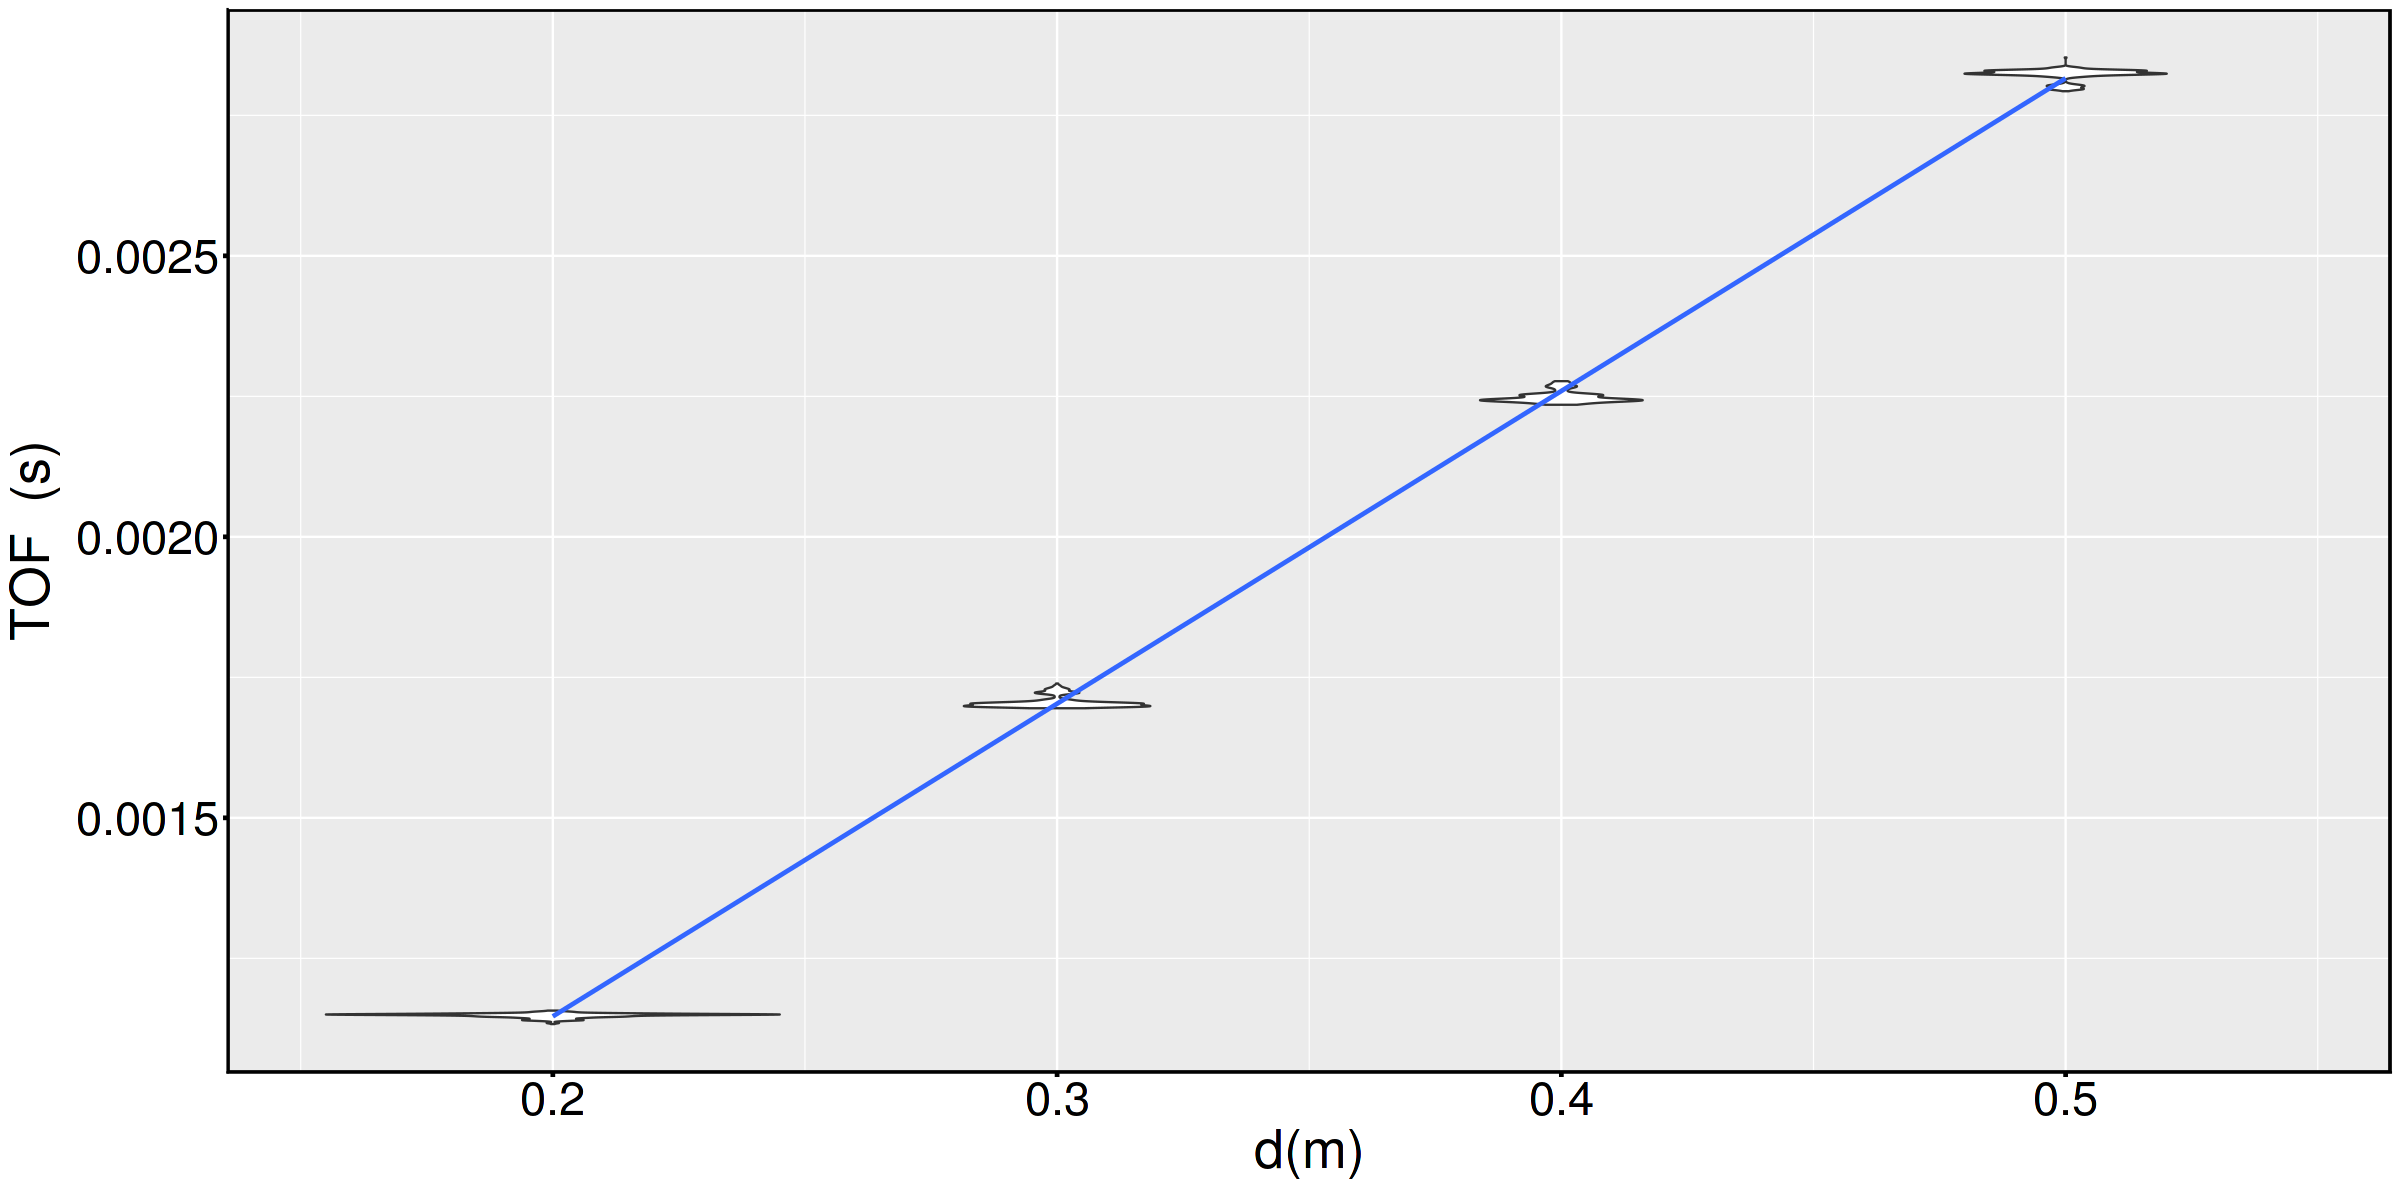

In [22]:
gtd2 <- ggplot(dn, aes(x  = d, y = TOF)) + 
geom_violin(aes(group = as.factor(d))) + 
geom_smooth(method = "lm", formula = "y ~ x", se = T, level = 0.999) + 
xlab(TeX("$d (m)$")) + ylab(TeX("$TOF \\; (s)$")) + 
temajuan
            
fig(20,10)
show(gtd2)

Se nota que para algunas distancias los TOF están arriba y para otras debajo...eso se traducirá como incertezas en la medición de la distancia...si miramos los residuos $\Delta$:

$$
\Delta = TOF_i - (a + b d_i)
$$

In [23]:
dn$residuos <- dn$TOF - (aju2$coefficients[1,1] + aju2$coefficients[2,1] * dn$d)

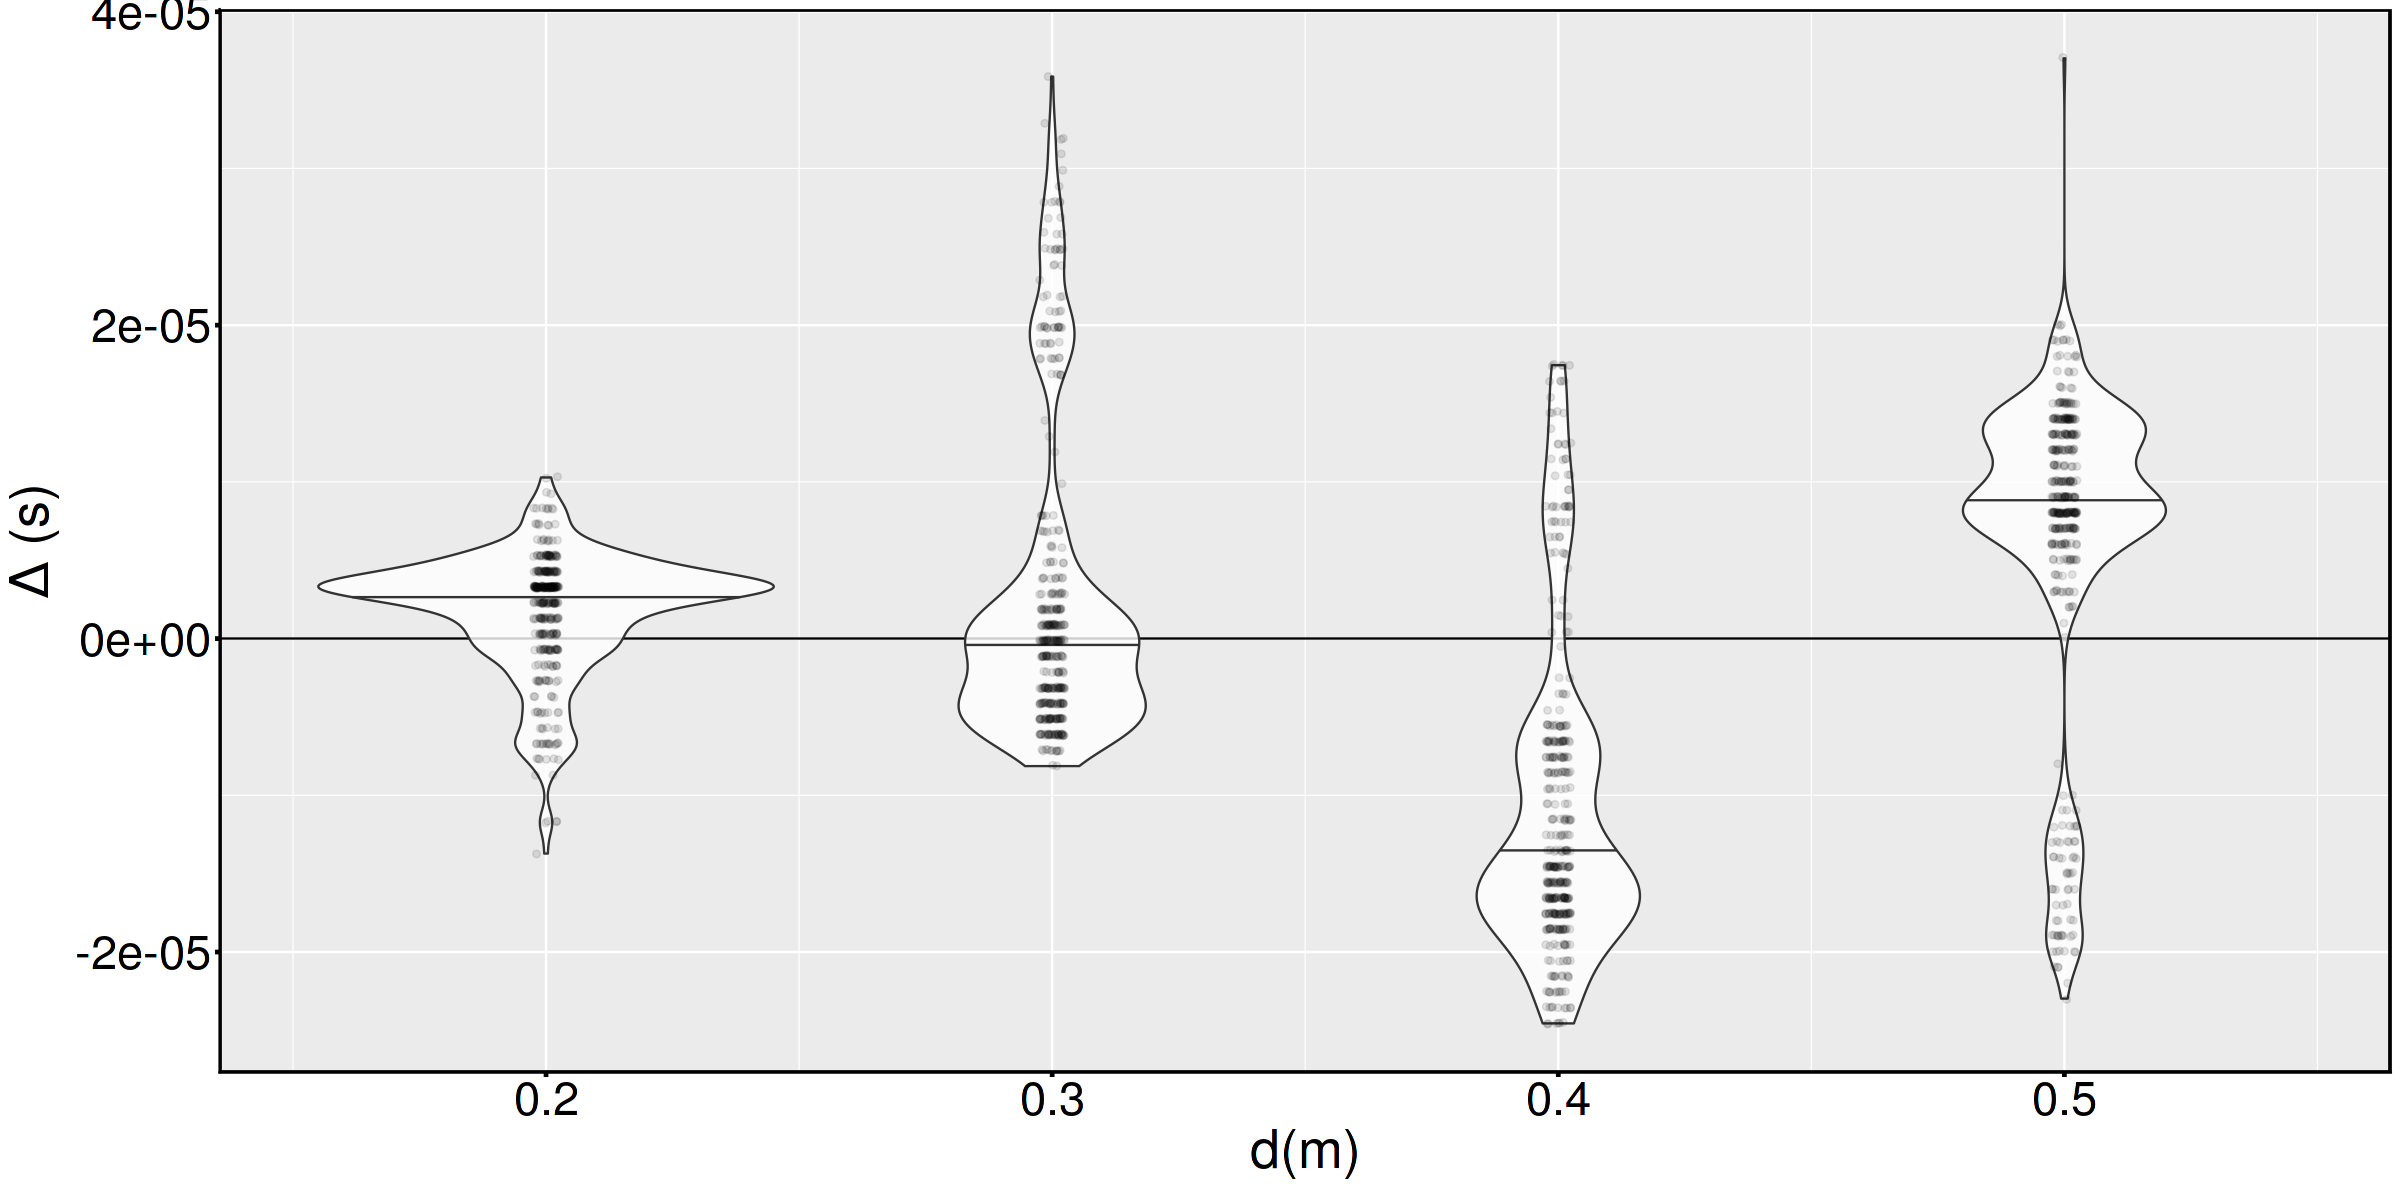

In [24]:
gr <- ggplot(data = dn, aes(x = d, y = residuos)) + 
geom_hline(aes(yintercept = 0)) + 
geom_violin(aes(group = as.factor(d)), draw_quantiles = c(0.5), alpha = 0.8) + 
geom_point(alpha = 0.1,position = position_jitter(0.0025)) + 
temajuan + ylab(TeX("$\\Delta \\, (s)$") )+ xlab(TeX("$d (m)$"))
show(gr)

Se ve que en este rango todo funciona fenómeno: si los residuos no superan en general los $20 \mu s$, entonces, si damos vuelta la función que ajustamos para obtener distancias, tendremos errores de aprox.:

$$
\delta d \sim \frac{359.44 m/s}{2} (20 \; 10^{-6}s) \sim 0.0036m = 3.65mm
$$

### Un histograma con KDE para los residuos.

In [43]:
gh <- ggplot(data = dn, aes(x = residuos)) + 
geom_histogram(aes(y = ..density.. ), bins = nclass.FD(dn$residuos), alpha = 0.3) +
geom_density() +
xlab(TeX("$\\Delta (s)$")) + ylab("Densidad de Probabilidad (1/s)") + 
ggtitle("Residuos del TOF para datos de Fabricio recortados.") + 
temajuan

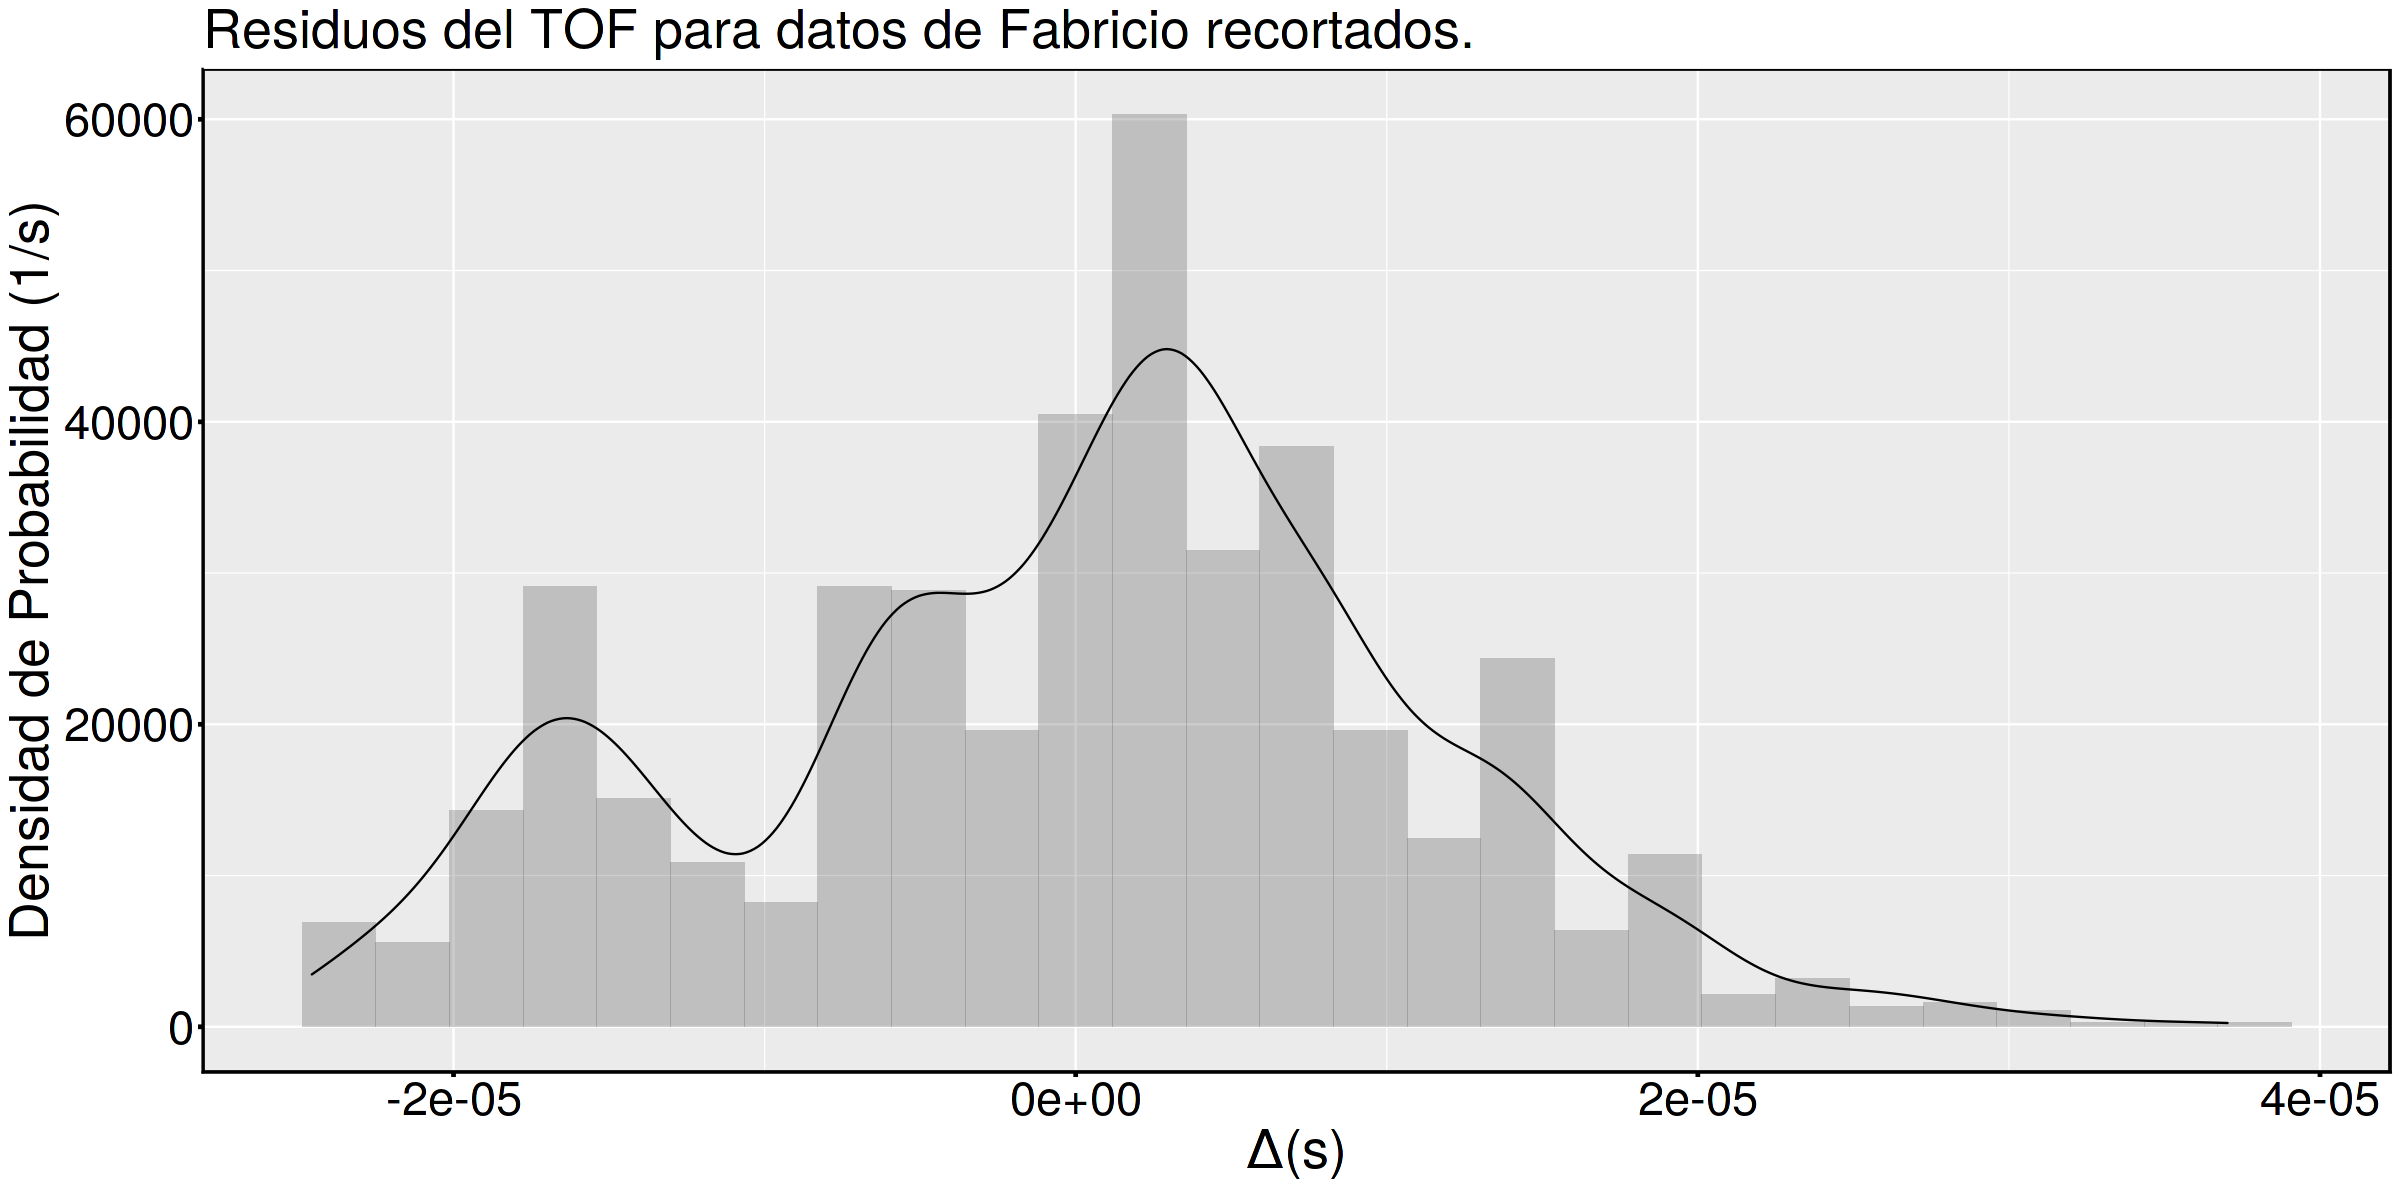

In [44]:
show(gh)

## Datos de Brisa y Felipe

In [20]:
datos <- "/home/juan/Documentos/Docencia/fexpi/2024/DatosLabo5/datos/BF/"
graf <- "/home/juan/Documentos/Docencia/fexpi/2024/DatosLabo5/graf/"
setwd(datos)

archivos <- list.files(pattern = ".csv"); archivos


[1] "Datos0.2 .csv" "Datos0.3 .csv" "Datos0.4 .csv" "Datos0.5 .csv"
 [5] "Datos0.6 .csv" "Datos0.7 .csv" "Datos0.8 .csv" "Datos0.9 .csv"
 [9] "Datos1.0 .csv" "Datos1.1 .csv" "Datos1.2 .csv"

In [21]:
datos <- data.frame();

for(i in archivos){

    datos.de.un.archivo <- read.csv(i, sep = ",", header = T, skip = 1);    
    #distancias    
    d <- rep(as.numeric(gsub(x = i, pattern = "Datos| .csv", replacement = "")), nrow(datos.de.un.archivo))
    datos.de.un.archivo$d <- d;
    datos <- rbind(datos, datos.de.un.archivo);
    }

colnames(datos) <- c("N", "TOF", "d");

In [22]:
datos$TOF <- datos$TOF/10^6 #tiempo de vuelo a segundos, así sale fácil

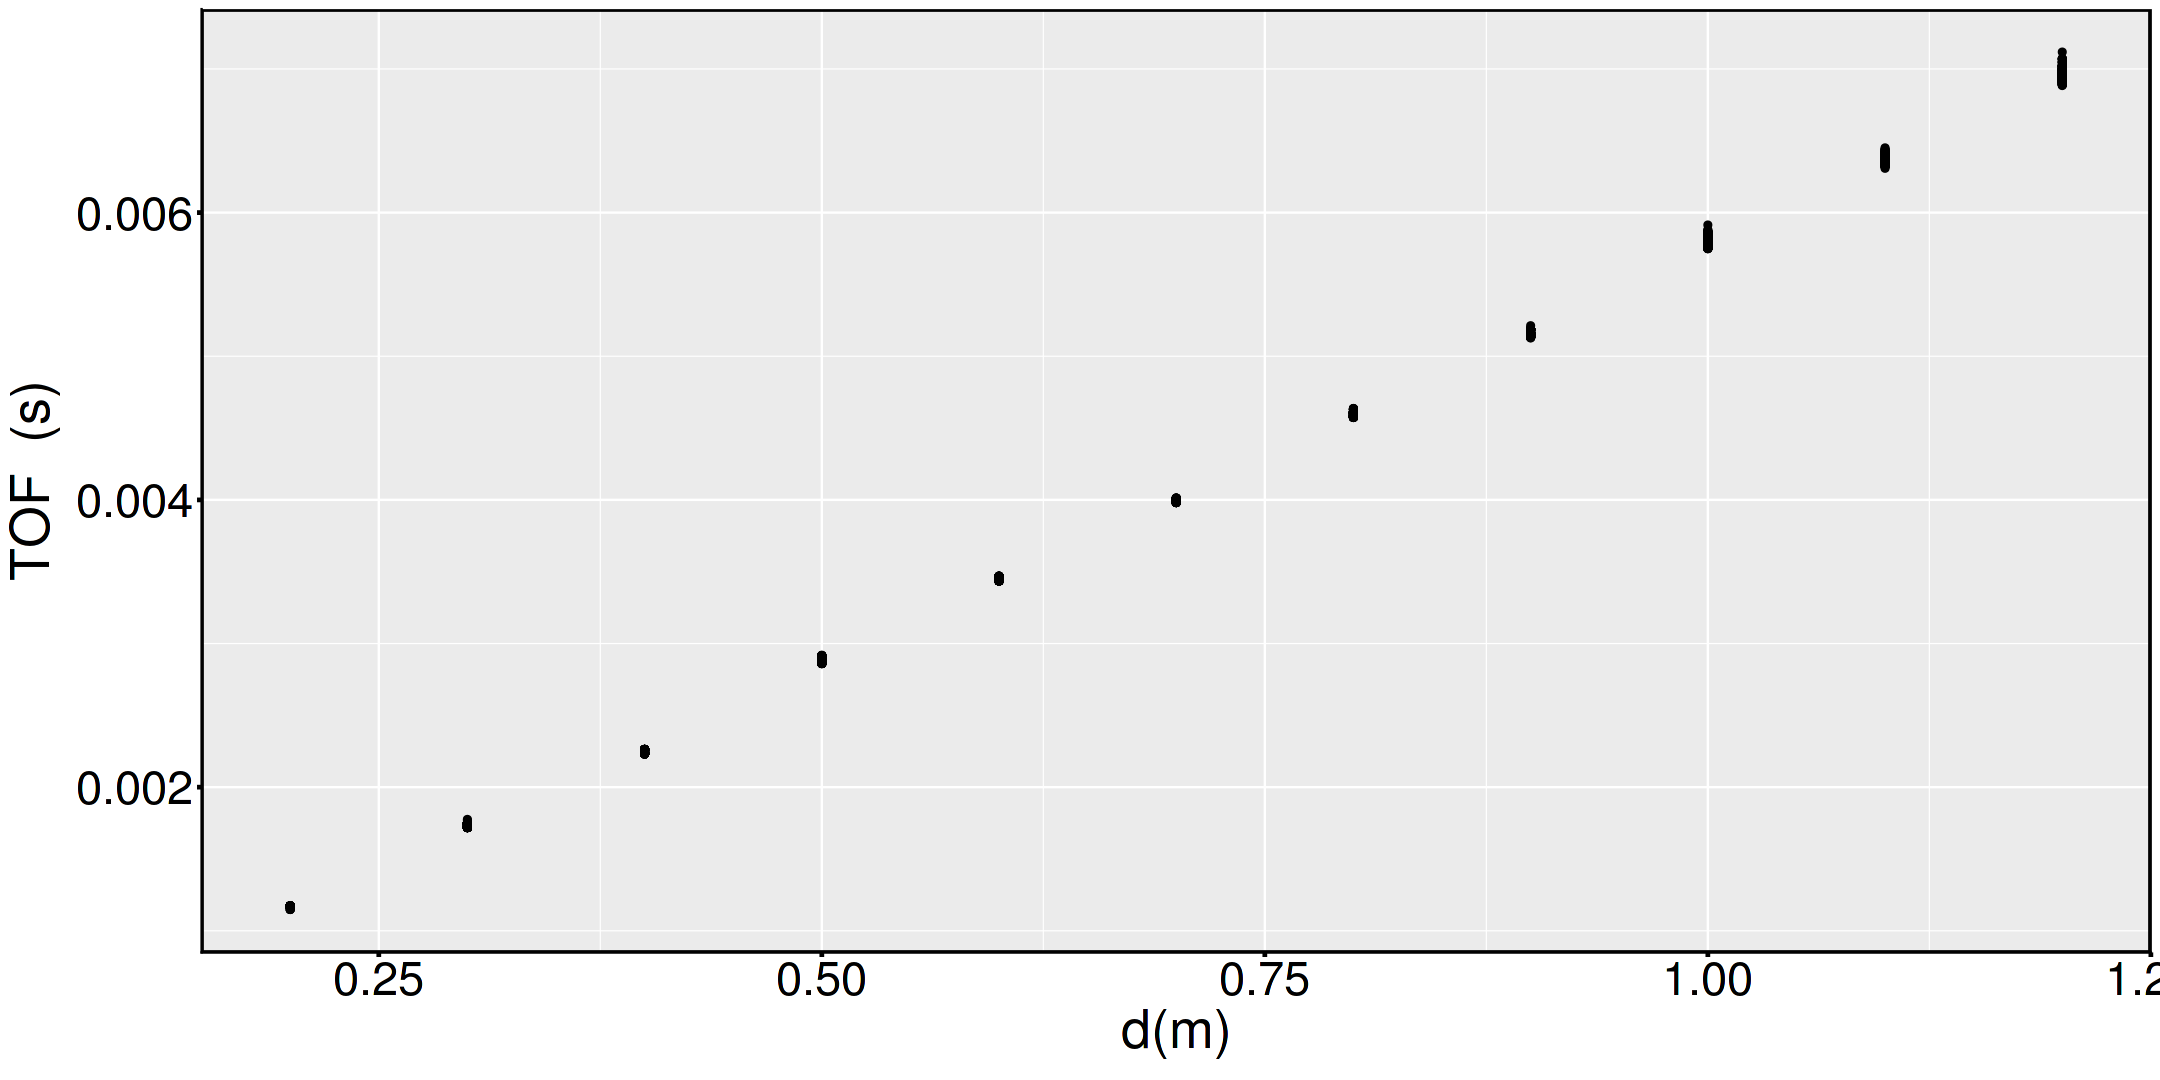

In [23]:
gtd <- ggplot() + 
geom_point(data = datos, aes(x = d, y = TOF)) +
temajuan + xlab(TeX("$d (m)$")) + ylab(TeX("$TOF \\; (s)$")) + 
theme(legend.box = "vertical", legend.position = c(0.2,0.7))
            

fig(18,9)
show(gtd)

Está tan bonito que pareciera ni siquiera hay que corregir nada. Ojo que esto no quiere decir que la velocidad del sonido nos va a dar 346 m/s...

## Ajustes

#### 1. Ajustamos todos los datos con dos parámetros

In [24]:
aju <- summary.lm(lm(datos$TOF ~ datos$d))
#velocidad del sonido a partir del ajuste
vs <- 2/aju$coefficients[2,1]
svs <- (2/aju$coefficients[2,1]^2) * aju$coefficients[2,2]

cat(bold("vs +- s = (", round(vs,4), " +- ", round(svs, 4), ")m s⁻¹"))

vs +- s = ( 345.0231  +-  0.0935 )m s⁻¹

jejejeje, increíble. La primera vez que pasa

#### Ajustamos todos los datos con un parámetro
Lo de arriba quiere decir que sólo utilizamos una pendiente.

In [79]:
aju2 <- summary.lm(lm(datos$TOF ~ 0 + datos$d))
#velocidad del sonido a partir del ajuste
vs2 <- 2/aju2$coefficients[1,1]
svs2 <- (2/aju2$coefficients[1,1]^2) * aju2$coefficients[1,2]

cat(bold("vs2 +- s = (", round(vs2,4), " +- ", round(svs2, 4), ")m s⁻¹"))

vs2 +- s = ( 347.1043  +-  0.0415 )m s⁻¹

No se pueden creer los valores....

In [86]:
T1 = (vs/20.0514)^2; 
T2 = (vs2/20.0514)^2; 
cat(bold("Las temperaturas dan \n\n"));
cat(bold("T1 = ", T1-273.16, " C (usano el ajuste TOF = a + b d)\n\n"))
cat(bold("T1 = ", T2-273.16, " C (usano el ajuste TOF = b d)"))

Las temperaturas dan 

T1 =  22.918494140352  C (usano el ajuste TOF = a + b d)

T1 =  26.5012732683113  C (usano el ajuste TOF = b d)

O sea que con un experimento con tan lindos resultados...no tenemos otra que decir que esta velocidad del sonido se podría usar de termómetro...jejeje

## Residuos

Hacemos los residuos para los dos ajustes y los graficamos y comparamos.

In [93]:
datos$residuosA <- datos$TOF - (aju2$coefficients[1,1] * datos$d)
datos$residuosAB <- datos$TOF - (aju$coefficients[1,1] + aju$coefficients[2,1] * datos$d)

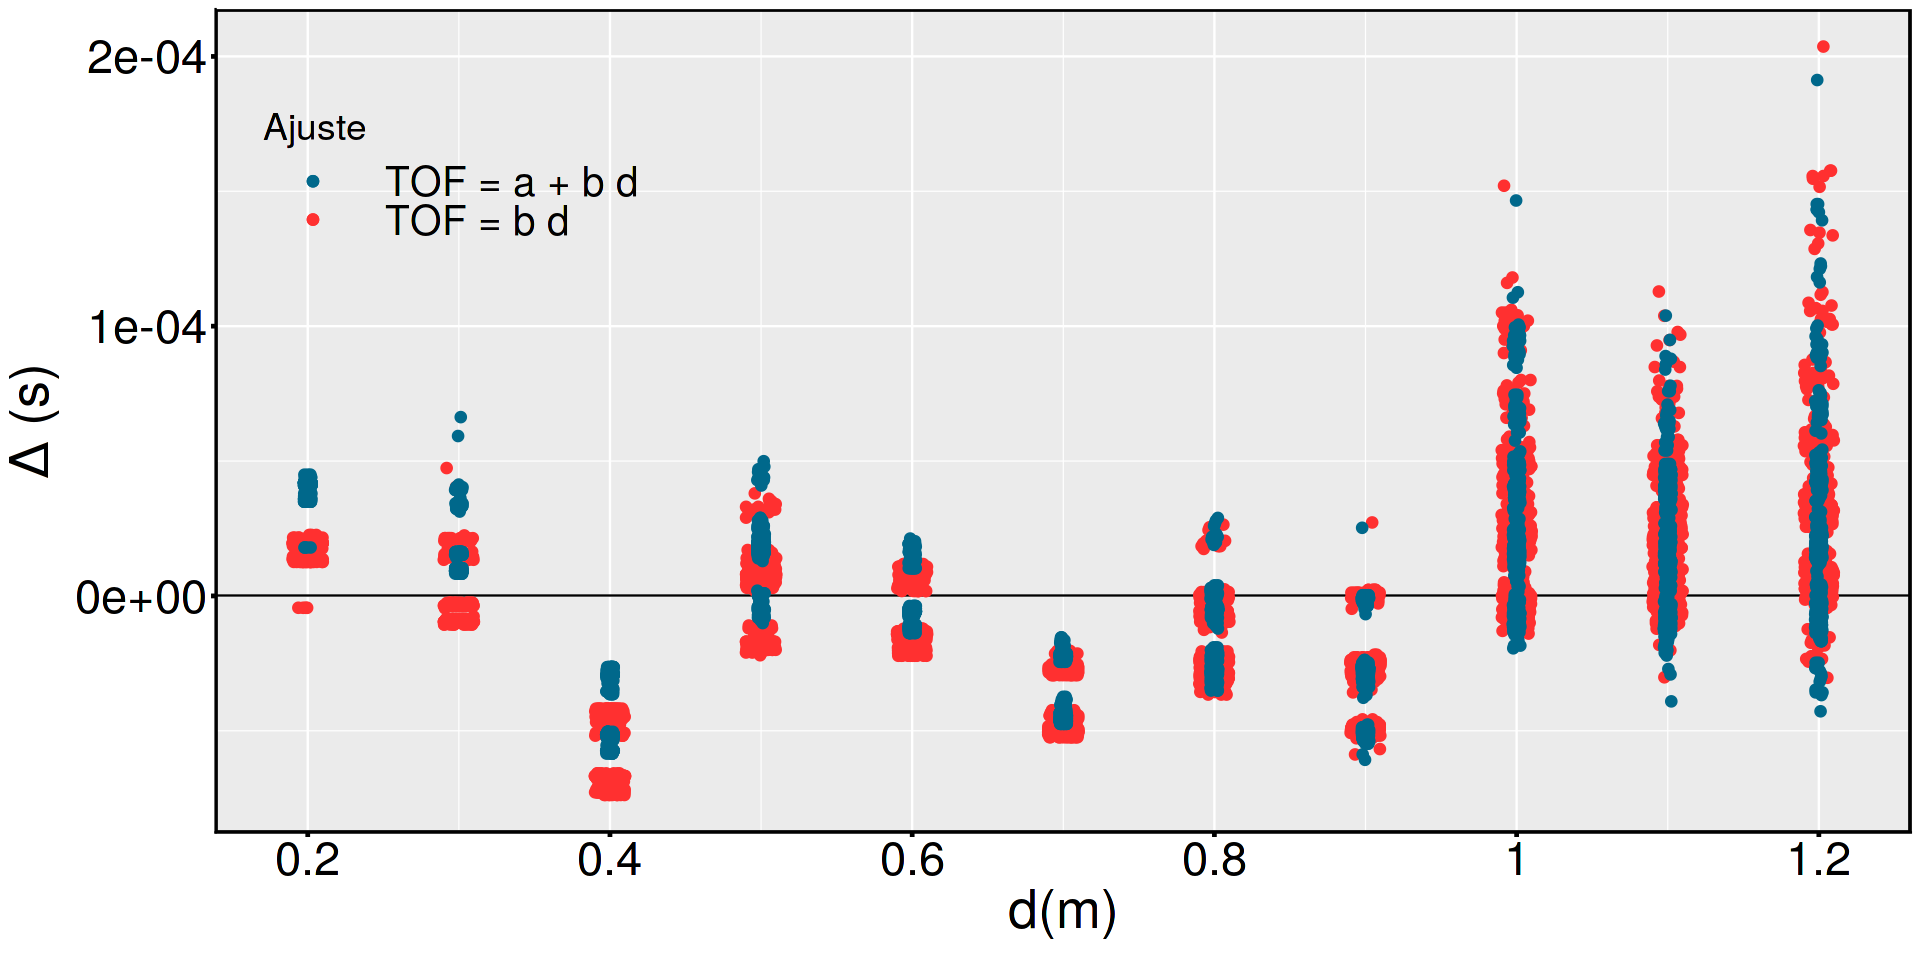

In [108]:
gr <- ggplot(data = datos, aes(x = d)) + 
geom_hline(aes(yintercept = 0)) + 
#geom_violin(aes(group = as.factor(d)), draw_quantiles = c(0.5), alpha = 0.8) + 
geom_point(aes(y = residuosA, colour = "TOF = b d"), alpha = 1,position = position_jitter(0.01), size = 2.5 ) + 
geom_point(aes(y = residuosAB, colour = "TOF = a + b d"), alpha = 1,position = position_jitter(0.0025), size = 2.5) + 
scale_colour_manual(values = c("TOF = a + b d"="DeepSkyBlue4", "TOF = b d" = "firebrick1"), name = "Ajuste") + 
temajuan + ylab(TeX("$\\Delta \\, (s)$") )+ xlab(TeX("$d (m)$")) + 
scale_x_continuous(breaks = seq(0.2,1.2,0.2), labels = seq(0.2,1.2,0.2))
fig(16,8)
show(gr)

Los residuos son casi iguales. Elegiría el ajuste con dos parámetros sólo porque tiene colas un poco más pequeñas.

Si bien los errores pueden parecer grandes (alrededor de 3 cm), esto pasa en todo el rango, mientras que en el caso de Fabricio los errores eran en un rango de 0.5 m.

In [135]:
library(scales)
gh <- ggplot(data = datos) + 
#geom_histogram(aes(y = ..density.. ), bins = nclass.FD(datos$residuosAB), alpha = 0.3) +
geom_density(aes(x = residuosAB, fill = "TOF = a + b d", colour = "TOF = a + b d"), alpha = 0.2 ,adjust = 1) +
geom_density(aes(x = residuosA,  fill = "TOF = b d", colour = "TOF = b d"), alpha = 0.2,adjust = 1) +
scale_fill_manual(values = c("TOF = a + b d"="DeepSkyBlue4", "TOF = b d" = "firebrick1"), name = "Ajuste") + 
scale_colour_manual(values = c("TOF = a + b d"="DeepSkyBlue4", "TOF = b d" = "Red3"), name = "Ajuste", ) + 
xlab(TeX("$\\Delta (s)$")) + ylab("Densidad de Probabilidad (1/s)") + 
ggtitle("Residuos del TOF para datos de Brisa y Felipe") + 
temajuan + theme(legend.position = c(0.8,0.8))

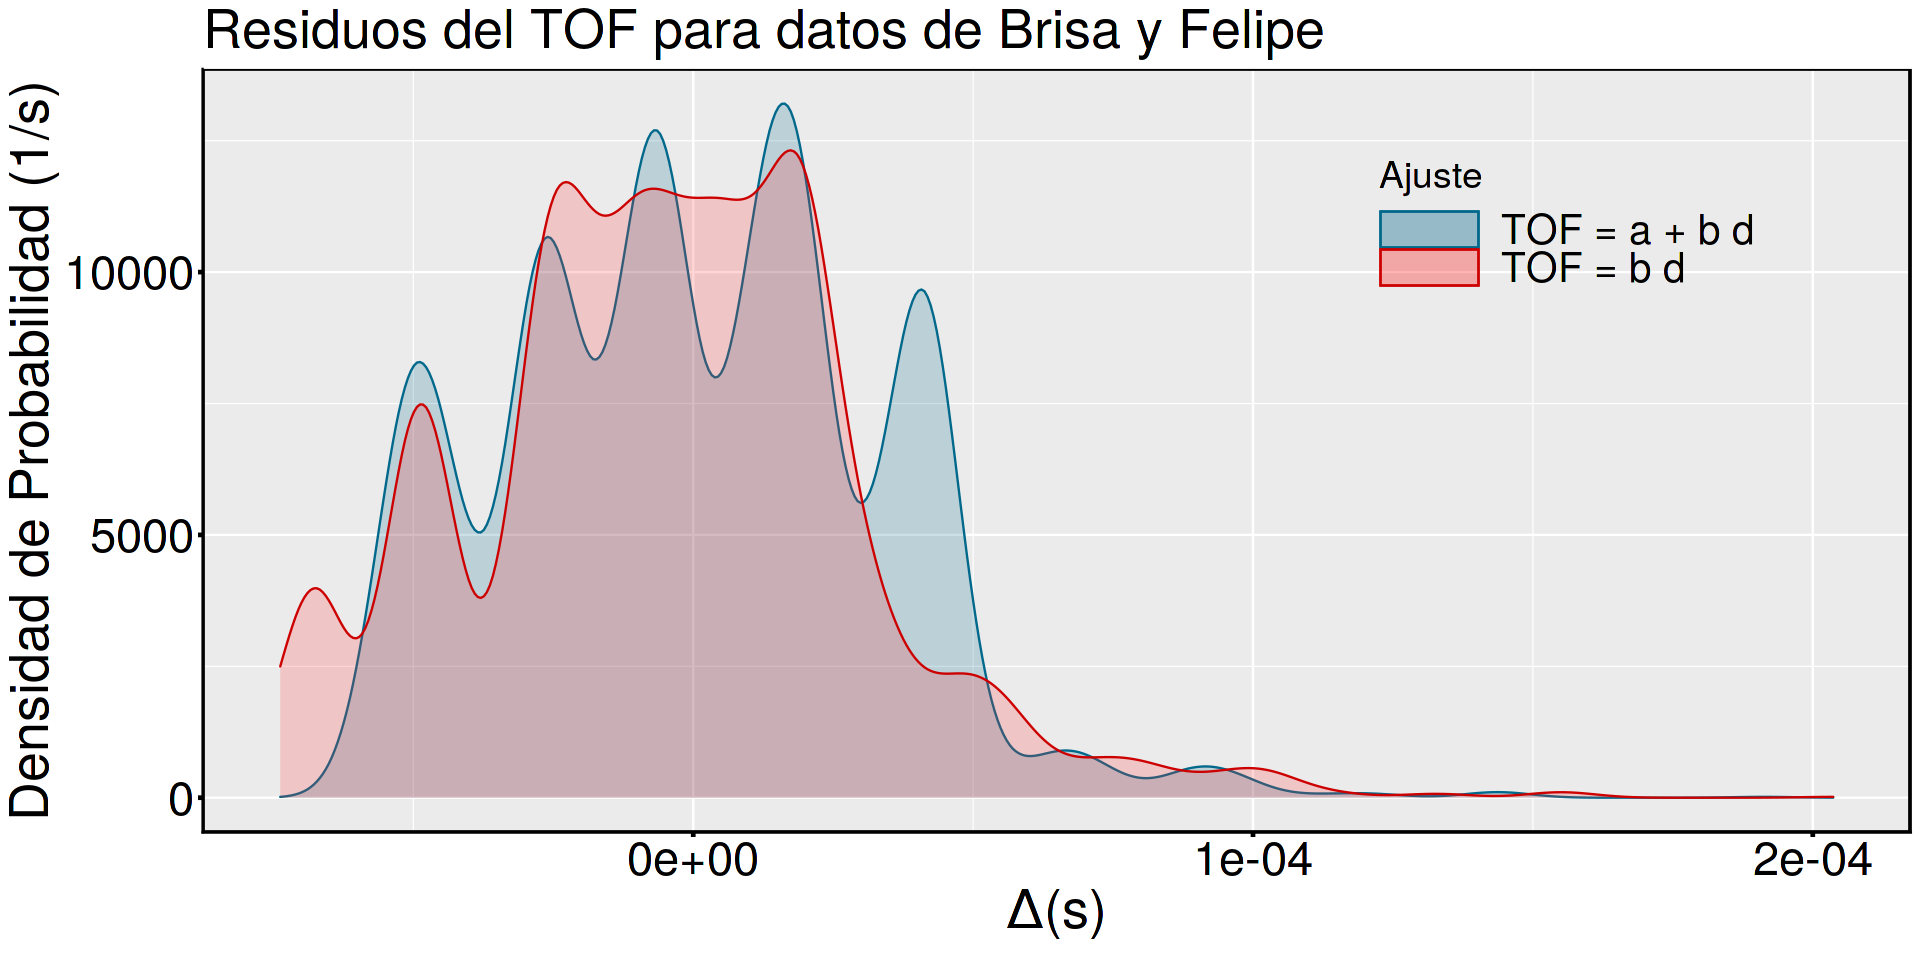

In [136]:
gh